Calculate functionals with symbolics 
create kernel 

Create points 

construnct distance tnsors 


apply kernel to a distance tensor 

assemble RHS and matrices 

Assemble DAE 

Solve with diffeq.jl or custom code 





In [1]:
using Revise
using CairoMakie
using Symbolics
using Latexify
using DifferentialEquations
using Sundials
using BenchmarkTools
cd("..")
include("RBFunctions.jl")
cd("circular_stokes_flow")
using Plots

In [2]:
mutable struct Sol
    t
    sol
end

In [3]:
function (p::Sol)(x) # linear intrpolation
    if x > p.t[end]
        error("out of bounds")
    end
    dt = p.t[2] - p.t[1]
    n = Int(x÷dt)+1
    rem = x%dt
    return p.sol[:,n]+(p.sol[:,n+1] - p.sol[:,n])*(rem/dt)
end

In [4]:
@variables ϵ r x₁ x₂ t Δt;
const nu = 1.0
μ = 0.0025
ρ = 1.0
#ϕ = 1//945 * ((ϵ*r)^5 +15*(ϵ*r)^3 + 105*(ϵ*r)^2 + 945*(ϵ*r)+ 945)* exp(-ϵ*r)
ϕ = exp(-r^2*ϵ^2)
ϕ = substitute(ϕ, r=>sqrt(x₁^2 + x₂^2)) 
#display(ϕ)  
Δ(exprs) = expand_derivatives((Differential(x₁)^2)(exprs) + (Differential(x₂)^2)(exprs))
∂₁(exprs) = expand_derivatives(Differential(x₁)(exprs))
∂₂(exprs) = expand_derivatives(Differential(x₂)(exprs))
∂ₜ(exprs) = expand_derivatives(Differential(t)(exprs))

Φ_div = ([-∂₂(∂₂(ϕ)) ∂₁(∂₂(ϕ)) 0.0 ; ∂₁(∂₂(ϕ)) -∂₁(∂₁(ϕ)) 0.0; 0.0 0.0 ϕ])
ΔΦ_div= Δ.([-∂₂(∂₂(ϕ)) ∂₁(∂₂(ϕ)); ∂₁(∂₂(ϕ)) -∂₁(∂₁(ϕ))])
Φ_curl = ([-∂₁(∂₁(ϕ)) -∂₁(∂₂(ϕ)); -∂₁(∂₂(ϕ)) -∂₂(∂₂(ϕ))])
Φ = [ϕ 0.0 0.0; 0.0 ϕ 0.0;0.0 0.0 ϕ]
#ΔΦ = [Δ(ϕ) 0 ; 0 Δ(ϕ)]

f₁ = 0.0
f₂ = 0.0
f₁ = eval(build_function(f₁,x₁, x₂, t))
f₂ = eval(build_function(f₂,x₁, x₂, t))
zero_func(x₁,x₂,t) = 0.0


λ1y(x) = x[1] - (Δt*μ/ρ)*Δ(x[1]) -  (Δt/ρ)*∂₁(x[3])
λ2y(x) = x[2] - (Δt*μ/ρ)*Δ(x[2]) -  (Δt/ρ)*∂₂(x[3])
λ3y(x) = x[1]
λ4y(x) = x[2]

λ1x(x) = x[1] - (Δt*μ/ρ)*Δ(x[1]) + (Δt/ρ)*∂₁(x[3])
λ2x(x) = x[2] - (Δt*μ/ρ)*Δ(x[2]) +  (Δt/ρ)*∂₂(x[3])
λ3x(x) = x[1]
λ4x(x) = x[2]

λu(x) = x[1]
λv(x) = x[2]
λp(x) = x[3]

λ∂₁u(x) = ∂₁(x[1])
λ∂₂u(x) = ∂₂(x[1])
λ∂₁v(x) = ∂₁(x[2])
λ∂₂v(x) = ∂₂(x[2])


λ∂₂v (generic function with 1 method)

In [5]:
#generate points for lid_driven_cavity
Internal_points,Boundary_points =  generate_2D_equally_spaced_points(20)
N_i = size(Internal_points)[2]
N_b = size(Boundary_points)[2]
N = N_i + N_b
top_points= zeros((2,1+Int(N_b/4)))
side_points = zeros((2,N_b-size(top_points)[2]))
s1,s2 = 1,1
for i in 1:N_b
    if Boundary_points[2,i] == 1.0
        top_points[:,s1] = Boundary_points[:,i]
        s1+=1
    else
        side_points[:,s2] = Boundary_points[:,i]
        s2+=1
    end
end
Boundary_points = hcat(top_points,side_points)
All_points = hcat(Internal_points,Boundary_points)

N_top = size(top_points)[2]
N_side = size(side_points)[2]
println("total number of nodes: ",N)
println("number of internal_nodes: ",N_i)
println(" number of top nodes: ",N_top)
println("number of side nodes: ",N_side)


total number of nodes: 400
number of internal_nodes: 324
 number of top nodes: 20
number of side nodes: 56


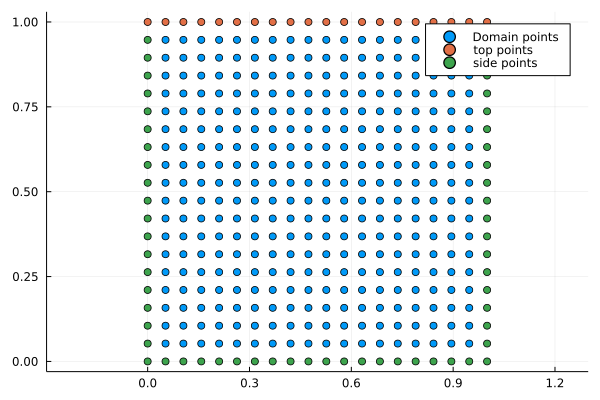

In [6]:
Plots.scatter(Internal_points[1,:],Internal_points[2,:],aspect_ratio=:equal,label = "Domain points")
Plots.scatter!(top_points[1,:],top_points[2,:],aspect_ratio=:equal,label ="top points")
Plots.scatter!(side_points[1,:],side_points[2,:],aspect_ratio=:equal,label ="side points")
#savefig("internal_domain_points.png")

In [7]:
parameter = 8
K = construct_kernel_array(Φ_div,[λ1x,λ2x,λ3x,λ4x],[λ1y,λ2y,λ3y,λ4y])
#display(build_function(K[1,1],[x₁,x₂],ϵ))
K = substitute.(K, Δt=>0.01)
K = compile_kernel_array(K)

R = construct_kernel_array(Φ_div,[λu,λv,λp],[λ1y,λ2y,λ3y,λ4y])
#display(R)
R = substitute.(R, Δt=>0.01) 
R = compile_kernel_array(R)

#non-linear term
Nl = construct_kernel_array(Φ_div,[λ∂₁u,λ∂₂u,λ∂₁v,λ∂₂v],[λ1y,λ2y,λ3y,λ4y])
#display(Nl)
Nl = substitute.(Nl, Δt=>0.01) 
Nl = compile_kernel_array(Nl)



T1 = crete_block_point_tensors([Internal_points,Internal_points,Boundary_points,Boundary_points],
[Internal_points,Internal_points,Boundary_points,Boundary_points])
#display(typeof(T1))
T2 = crete_block_point_tensors([Internal_points,Internal_points,Internal_points],
[Internal_points,Internal_points,Boundary_points,Boundary_points])

T3 = crete_block_point_tensors([Internal_points,Internal_points,Internal_points,Internal_points],
[Internal_points,Internal_points,Boundary_points,Boundary_points])

A = generate_block_matrices(K,T1,parameter)
A = flatten(A)

S = generate_block_matrices(R,T2,parameter)
S = flatten(S)

D = generate_block_matrices(Nl,T3,parameter)
D = flatten(D)

println(cond(A))


function g(t)
    res = zeros(N_b*2)
    res[1:N_top] .= min(t,8.0)
    return res
end

f = generate_vector_function([f₁,f₂],Internal_points)

g(1.2)
print("done")

1.8680737790612257e9
done

In [8]:
g(1.2)[N_top+1]

0.0

In [12]:

function generate_solution(A,S,D,u0,dt,N_t,N_i,N_b,f,g)
    n = size(S)[1]
    RHS = zeros(N_i*2+2*N_b)
    RHS[1:2*N_i] .= u0 .+ dt*f(0.0+dt)
    RHS[2*N_i+1:end] .= g(0.0+dt)
    A_inv = inv(A)
    solution_array = zeros((n,N_t+1))
    u = vcat(u0,zeros(N_i))
    solution_array[:,1] .= u
    der = zeros(4*N_i)
    t_array = [0.0]
    for i in 1:N_t
        append!(t_array,[i*dt])
        c = A_inv*RHS
        u = S*c

        #RHS[1:N_i] .+= (-der[1:N_i] .* u[1:N_i]) .- (der[N_i+1:2*N_i] .* u[1+N_i:2*N_i])*dt
        #RHS[1+N_i:2*N_i] .+= (-der[2*N_i+1:3*N_i] .* u[1:N_i]) .- (der[3*N_i+1:4*N_i] .* u[1+N_i:2*N_i])*dt

        der = D*c
        solution_array[:,i+1] .= u
        # update RHS for next iteration

        RHS[1:2*N_i] .= u[1:2*N_i] .+ dt*f((i+1)*dt)
        RHS[2*N_i+1:end] .= g((i+1)*dt)
        # add nonlinear term 
        

    end
    solution = Sol(t_array,solution_array)
    return solution
end
u0 = zeros(2*N_i)
dt = 0.01
N_t = 1000
solution = generate_solution(A,S,D,u0,dt,N_t,N_i,N_b,f,g)


Sol([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  9.91, 9.92, 9.93, 9.94, 9.950000000000001, 9.96, 9.97, 9.98, 9.99, 10.0], [0.0 5.212234246892939e-7 … -0.00572321157629206 -0.00572629186090181; 0.0 -5.25350913464086e-7 … -0.01637729979620229 -0.016377619292562248; … ; 0.0 0.00028506909011893726 … 0.34333987164777013 0.3433032626063741; 0.0 0.00039622791822412073 … 0.5001441750174802 0.500096360111643])

In [10]:
maximum(solution.sol[1:2*N_i,:])

5.402822644134346

In [14]:
time = Observable(0.0)
xs = Internal_points[1,:]
ys = Internal_points[2,:]
us = @lift solution($time)[1:N_i] #- u_true($time)[1:N_i]
vs = @lift solution($time)[N_i+1:2*N_i]  #- u_true($time)[N_i+1:end] 
title = @lift string(round($time, digits=2))
strength2 = @lift 10*sqrt.(solution($time+0.01)[1:N_i] .^ 2 .+ solution($time+0.01)[N_i+1:2*N_i] .^ 2) 

fig = Figure(resolution = (800, 800))
Axis(fig[1, 1], backgroundcolor = "black",title = title)
arrows!(xs, ys, us, vs, arrowsize = 10, lengthscale = 0.03, arrowcolor = strength2, linecolor = strength2) #, 
framerate = 30
timestamps = range(0.0, 9.9, step=1/framerate)
record(fig, "Navier_stokes.gif", timestamps; framerate = framerate) do ti
    time[] = ti
end


"Navier_stokes.gif"